# IV Calculation for call options

### Black-Scholes Model

$C=\Phi(d_1)S - \Phi(d_2)Ke^{-rt}$ \
$P = \Phi(-d_2)Ke^{-rt} - \Phi(-d_1)S$ \
$d_1 = \frac{1}{\sigma \sqrt(t)}[log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t]$ \
$d_2 = d_1 - \sigma \sqrt(t) $


Say we have observed a call price $C_0$ \
and we are looking for a value $\sigma$, such that \
$\Phi(d_1)S - \Phi(d_2)Ke^{-rt} - C_0 = 0$


note that we need a derivative of C w.r.t $\sigma$ \
$\nu = \frac{\partial C}{\partial \sigma} = S \phi(d_1)\sqrt{t}$

We will use Newton's method(see Appendix)

In [303]:
from numpy import sqrt, exp, log, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import date,datetime,timedelta
import warnings
#from scipy.interpolate import griddata
import plotly.graph_objects as go
from arch import arch_model
import nbformat
from matplotlib.colors import Normalize
%matplotlib inline

In [178]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [179]:
warnings.filterwarnings("ignore")

### Black-Scholes formula, for a call option

In [180]:
def option_price(sigma, S, K, r, t,type = "c"):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    P = np.multiply(norm.cdf(-d2) * K, np.exp(-r * t)) - \
        np.multiply(S,norm.cdf(-d1))
    if type == "c":
        return C
    elif type == "p":
        return P
    else:
        print("You must specify the type correctly (c or p)!!!")
    

### Objective function used for optimization

In [181]:
def objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return option_price(sigma, S, K, r, t) - price

### Vega calculation

In [182]:
def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)

### Newton's method

In [219]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    try:
        # Convert warnings to exceptions
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)
            count = 0
            epsilon = 1
    
            while epsilon >= tol:
                count += 1
                if count >= max_iter:
                    print('Forced exit, the loop runs away')
                    return (R, count)
        
                old_R = R
        
                function_value = f(R, args = args)
                function_derivative = fprime(R, args = args)
        
               
                R = -function_value / function_derivative + R
        
                epsilon = np.abs( (R - old_R) / old_R)
                if debug == True:
                    print('Iteration = ', count, 'f = ', function_value, 'fprime = ', function_derivative, 'Tol = ', epsilon)
        
            return R
    except RuntimeWarning:
        # Handle RuntimeWarnings here
        return None
    except Exception:
        # Handle all other exceptions here
        return None

# Get real data

#### Function to fetch data for options

#### We need:
1) option price c0
2) spot price S
3) strike price K
4) interest rate r
5) time to expiration t

In [220]:
def options_data(ticker,option_type = "call",oi_lower_bound=100):
    asset = yf.Ticker(ticker)
    exp_dates = asset.options #expiration dates for options
    data = pd.DataFrame() #dataframe for keeping of downloaded options
    for exp in exp_dates:
        options = asset.option_chain(exp)
        calls = options.calls
        calls["optionType"] = "call"
        puts = options.puts
        puts["optionType"] = "put"
        d = pd.concat([calls,puts])
        d["expiration"] = pd.to_datetime(exp)+pd.DateOffset(hours=23,minutes=59,seconds=59)
        data = pd.concat([data,d])
    data["dte"] = (data["expiration"] - dt.datetime.today()).dt.days + 1
    data = data[["strike","lastPrice","volume","openInterest","optionType","dte","impliedVolatility"]]
    data = data[data["openInterest"]>oi_lower_bound]
    if option_type == "call":
        call_chain = data[data["optionType"] == "call"]
        return call_chain
    elif option_type == "put":
        put_chain = data[data["optionType"] == "call"]
        return put_chain
    else:
        return data


### Example for AAPL

In [221]:
aapl_c = options_data("AAPL",oi_lower_bound=100)

In [222]:
aapl_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 757 entries, 0 to 60
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   strike             757 non-null    float64
 1   lastPrice          757 non-null    float64
 2   volume             757 non-null    float64
 3   openInterest       757 non-null    int64  
 4   optionType         757 non-null    object 
 5   dte                757 non-null    int64  
 6   impliedVolatility  757 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 47.3+ KB


In [223]:
S_aapl = yf.download("AAPL")["Close"].iloc[-1].iat[-1]
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Calculation of implied volatility for aapl_c dataframe

In [224]:
aapl_c["iv"] = aapl_c.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_aapl,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

Forced exit, the loop runs away


#### A test with fixed arguemnts

In [225]:
S = S_aapl                   #  Index price
K = 250.0             #  Strike price
r = r_1y                      #  Risk-free rate
t = 3.0/365.0                    #  Time until expiration
C0 = 0.05      #  Call price taken to be the midprice between the bid and ask

args = (S, K, r, t, C0)  
newtons_method(objective_function,calculate_vega,0.5,args=args) 

np.float64(0.30809305204816867)

### Surface plot

In [340]:
def plot_iv_values(data):
    x = data['strike'].values
    y = data['dte'].values
    z = data['iv'].values

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    norm = Normalize(vmin=data["iv"].min(),vmax=data["iv"].max())
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis',norm=norm)

    cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
    cbar.set_label('Implied Volatility values')

    ax.set_xlabel('Strike prices')
    ax.set_ylabel('DTE (Days to Expiration)')
    ax.set_zlabel('IV (Implied Volatility)')

    ax.set_title('Implied Volatility')

    plt.show()


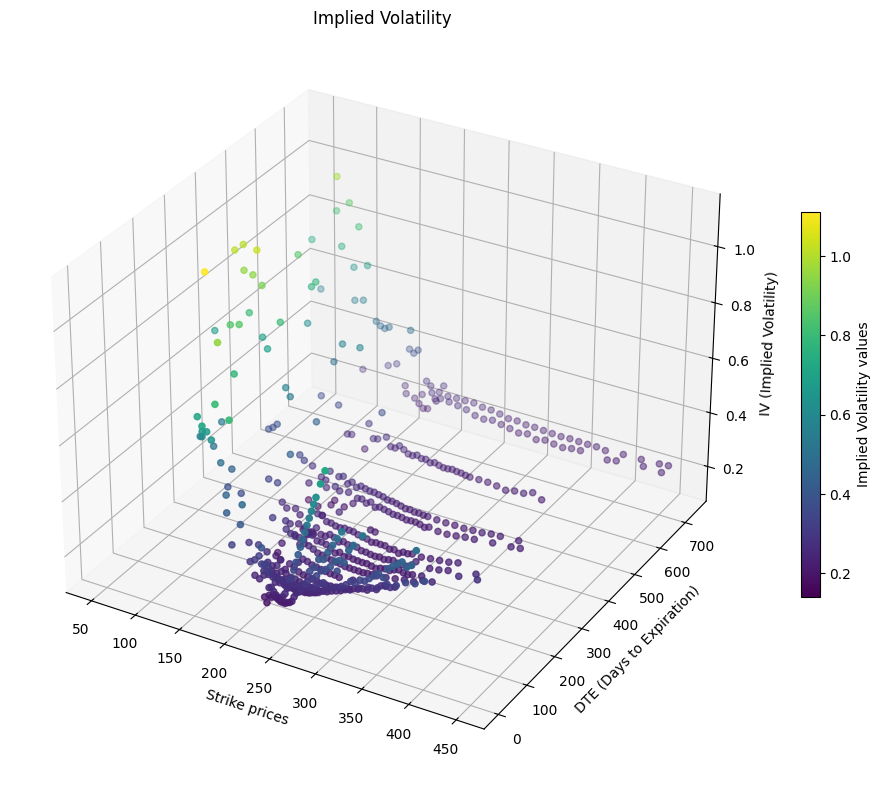

In [341]:
plot_iv_values(data_options)

### Interactive Plot

In [356]:
def plot_iv_values_inter(d):
    fig3 = go.Figure(
        data=[
            go.Scatter3d(
                x=d["strike"],  # X-axis
                y=d["dte"],     # Y-axis
                z=d["iv"],      # Z-axis
                mode='markers',
                marker=dict(
                    size=5,
                    color=d["iv"],  # Color by "iv" values
                    colorscale='Viridis',  # Color scale
                    opacity=0.8
                )
            )
        ]
    )

# Customize layout
    fig3.update_layout(
        title="Volatility Surface plot",
        scene=dict(
            xaxis_title="Strike",
            yaxis_title='Days to Expiration',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

# Show the plot
    return fig3.show()

In [357]:
plot_iv_values_inter(data_options)

## Volatility Measures

#### Historical Volatility

In [282]:
def hist_vol(ticker,window):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close
    log_ret = np.log(ticker_data/ticker_data.shift())
    hist_vol = (log_ret.rolling(window).std().dropna())*np.sqrt(252)
    last_30_values = hist_vol[-30:]
    last_value = round(hist_vol.iloc[-1,-1],4)
    print(f"The last value of historical volatility based on {window}-day window is {last_value}")

    fig,ax = plt.subplots(figsize = (14,6))
    ax.plot(last_30_values,label = "Line Plot",color = "black")
    ax.set_title(f"{window}-day historical volatility values (annualized)",fontsize = 20)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return plt.show(fig)

[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 30-day window is 0.1857


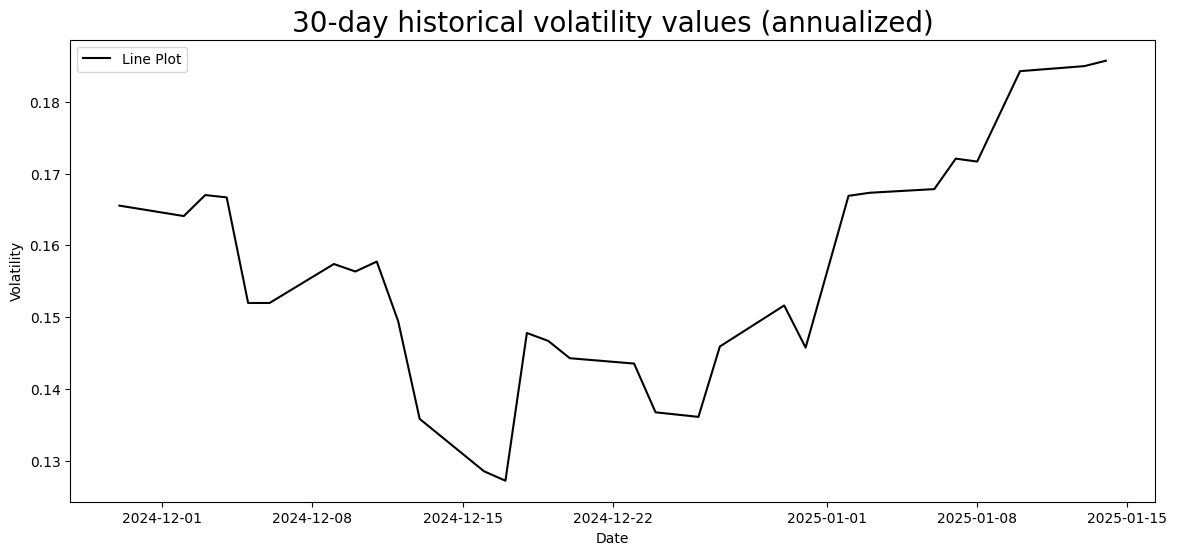

In [283]:
hist_vol("AAPL",30)

#### GARCH Conditional Volatility

Fit and plot of conditional volatility based on GARCH(1,1):

In [284]:
def garch_vol(ticker,train_period = 1000,graph_window=22,forecast_horizon=3):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close[-train_period:]
    log_ret = np.log(ticker_data/ticker_data.shift()).dropna()
    model = arch_model(log_ret,p=1,q=1)
    model_fit = model.fit(disp="off")
    c_vol = model_fit.conditional_volatility*np.sqrt(252)
    pred = model_fit.forecast(horizon=forecast_horizon)
    vol_pred_values = np.sqrt(pred.variance.values[-1])*np.sqrt(252)
    pred_index = pd.date_range(date.today(),date.today()+timedelta(forecast_horizon-1))
    pred_df = pd.DataFrame(vol_pred_values,index=pred_index)
    
    all_values = np.concatenate([c_vol,vol_pred_values])
    start_date = datetime.date(c_vol.index[0])
    end_date = date.today()+timedelta(forecast_horizon-1)
    index_all = c_vol.index.append(pd.bdate_range(start=date.today(),end = date.today()+timedelta(forecast_horizon-1)))

    all_values_df = pd.DataFrame(all_values,index = index_all)
    plt.figure(figsize=(12,6))
    plt.plot(all_values_df[-graph_window:])
    plt.plot(pred_df,color = "red")
    plt.axvline(date.today(),color = "grey",linestyle = "--")

### Greeks

In [285]:
r = 0.01
S = 30
K = 40
t = 240/365
sigma = 0.3

In [286]:
option_price

<function __main__.option_price(sigma, S, K, r, t, type='c')>

In [287]:
option_price(sigma,S,K,r,t,type = "c")

np.float64(0.5132843798399414)

#### Delta

$delta = \frac{\partial P}{\partial S}$ \
$delta(call) = \Phi(d_1)$ > 0 \
$delta(put) = -\Phi(-d_1) < 0$

In [288]:
def delta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    if type == "c":
        delta_value = norm.cdf(d1)
    elif type == "p":
        delta_value = - norm.cdf(-d1)
    return delta_value

#### Gamma

$Gamma = \frac{\partial Delta}{\partial S^2}$ 

$Gamma = \frac{\phi(d_1)}{S\sigma\sqrt{t}}$

In [289]:
def gamma(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    gamma_value = (norm.pdf(d1))/(S*sigma*np.sqrt(t))
    return gamma_value

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ 

We have already defined vega, function: calculate_vega 

- it was neccessary(as an input for the Newton's algortihm), since it is a derivative of the option price w.r.t. $\sigma$
- function name: calculate_vega

In [290]:
calculate_vega

<function __main__.calculate_vega(sigma, args)>

#### Theta

$Theta = - \frac{\partial P}{\partial t}$ 

call: $Theta = -\frac{S \phi(d_1)\sigma}{2t} - rKexp(-rt)\Phi(d_2)$

put: $Theta = -\frac{S \phi(d_1)\sigma}{2t} + rKexp(-rt)\Phi(-d_2)$

In [291]:
def theta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) - r*K*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) + r*K*np.exp(-r*t)*norm.cdf(-d2)
    return theta_value/365 #to obtain time decay per day, not years

### Rho

$Rho = \frac{\partial P}{\partial r}$

call: $Rho = KTexp(-rt)\Phi(d_2) > 0$ 

 put: $Rho = -KTexp(-rt)\Phi(-d_2) < 0$ 

In [292]:
def rho(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        rho_value = K*t*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        rho_value = -K*t*np.exp(-r*t)*norm.cdf(-d2)
    return rho_value*0.01 #to obtain sensitivity to 1% change in rates

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ \
$Vega = S \phi(d_1) \sqrt{t}$

In [293]:
def vega(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    vega_value = S*norm.pdf(d1,0,1)*np.sqrt(t)
    return vega_value
    


In [294]:
greek_fun = {"delta":delta,
                 "gamma":gamma,
                 "rho":rho,
                 "theta":theta,
                 "vega":vega}
def greeks(sigma, S, K, r, t,type):
    result = {name: func(sigma, S, K, r, t,type) for name,func in greek_fun.items()}
    return pd.DataFrame([result]).reset_index(drop=True)

---------------------------------------------------------------------------- 

---------------------------------------------------------------------------- 

----------------------------------------------------------------------------


# Final Screen

### Function: hist_vol
Inputs:
- ticker
- the time window (days) for the calculation of historical volatility


[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 60-day window is 0.1733


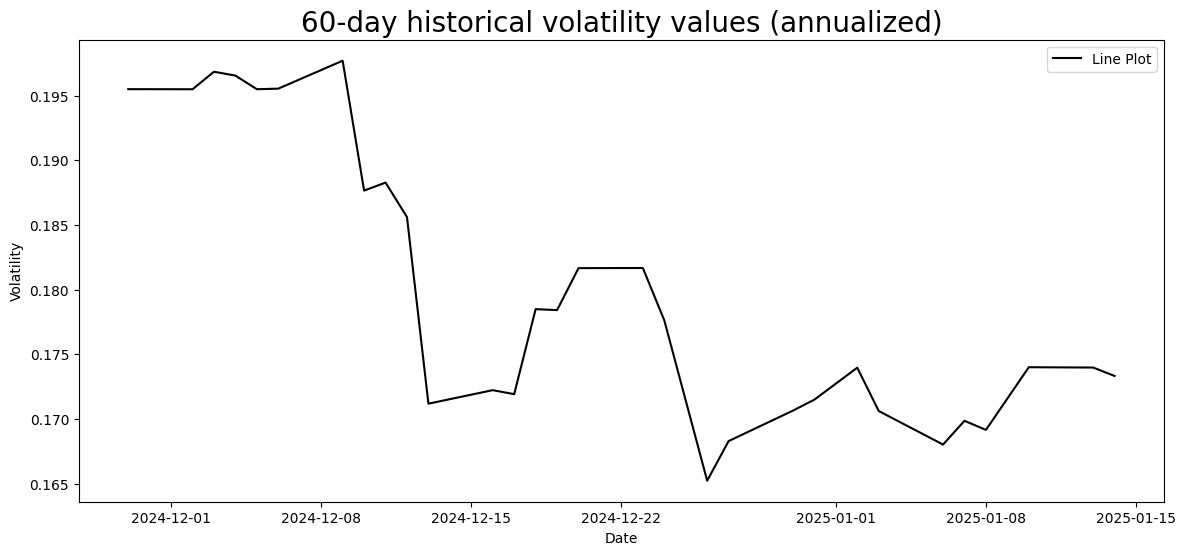

In [295]:
hist_vol("AAPL",60)

### Function: garch_vol 
Inputs:
- ticker 
- train_period: the size of the lookback period (days) for training of the GARCH(1,1) model 
- graph_window: number of days displayed on the plot of conditional volatility
- forecast_horizon: number of days to be forecasted(including today)



[*********************100%***********************]  1 of 1 completed


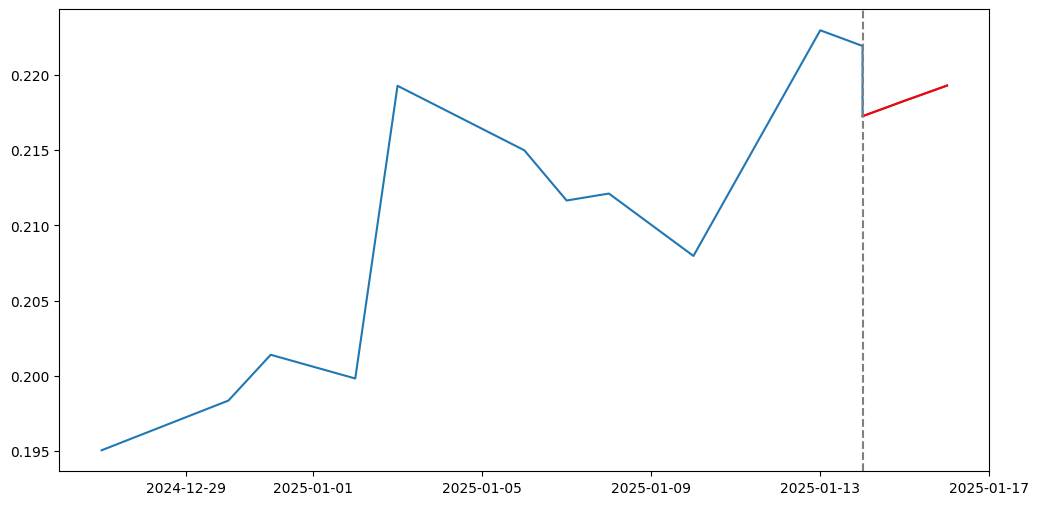

In [359]:
garch_vol("AAPl",train_period=1000,graph_window=14,forecast_horizon=3)

### Function: greeks 

Inputs:
- sigma: volatility
- S: spot price
- K: strike price
- r: interest rate
- t: time (years) to expiration
- type: type of the option (c = call, p = put) 

Obtain a data frame with option greeks: delta, gamma, rho, theta, vega

In [297]:
greeks(sigma= 0.2,S = 100,K = 100,r = 0.05,t = 10/365,type = "c")

,delta,gamma,rho,theta,vega
0,0.523099,0.120309,0.013951,-0.405249,6.592268


### Function: options_data 

Inputs:
- ticker
- option_type: required option type
- oi_lower_bound: lower bound for open interest in given options(excludes scarcely traded options, with open interest being below the given lower bound)

In [361]:
ticker = "AAPL" #Input the required ticker
option_type = "call" #The calculation is adapted for call options
oi_lower_bound = 100 #Input the required lower bound of the open interest

In [362]:
S_ticker = yf.download(ticker)["Close"].iloc[-1].iat[-1] #The last closing price for the given ticker
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100 #Interest rate for the calculation, based on US-Treasury 1-year yield
print(f"The latest available spot price of the specified ticker is {round(S_ticker,4)}")
print(f"The interest rate used in the calculation is {round(r_1y*100,4)}%")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

The latest available spot price of the specified ticker is 234.445
The interest rate used in the calculation is 4.213%


In [363]:
data_options = options_data(ticker,option_type,oi_lower_bound).dropna()
data_options["iv"] = data_options.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_ticker,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

### Function: plot_iv_values

Inputs:
- data_options: a data frame with 3 columns:
1) strike: strike prices of options
2) dte: days to expiration
3) iv: column with the values of calculated implied volatility

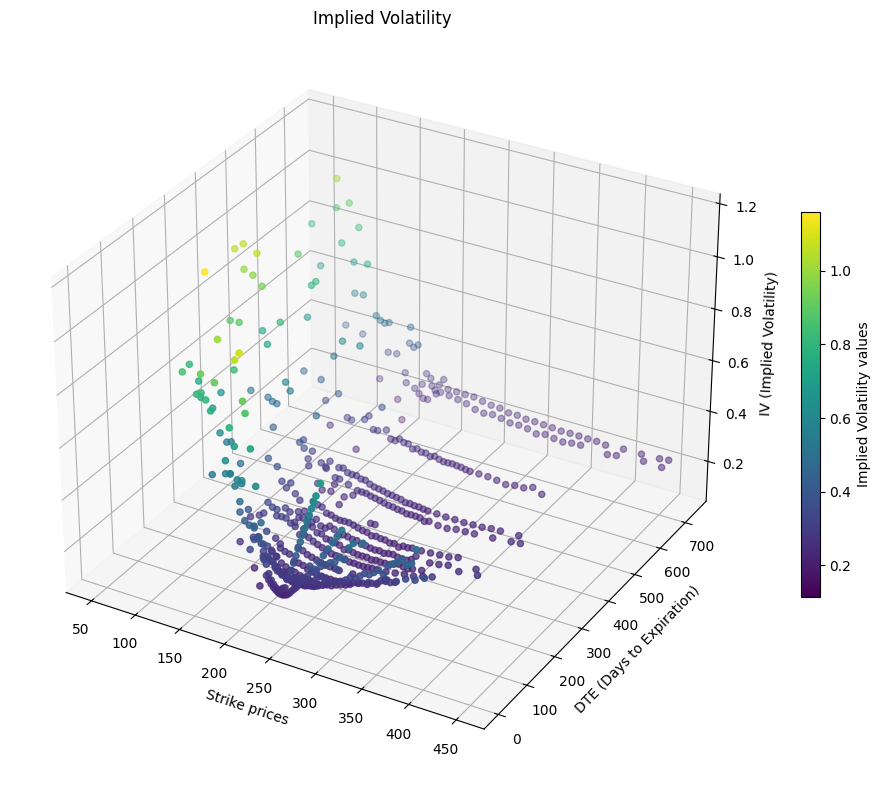

In [364]:
plot_iv_values(data_options)

### Function: plot_iv_values_inter
- data_options: a data frame with 3 columns:
1) strike: strike prices of options
2) dte: days to expiration
3) iv: column with the values of calculated implied volatility

In [365]:
plot_iv_values_inter(data_options)

---------------------------------------------------------------------------- 

---------------------------------------------------------------------------- 

----------------------------------------------------------------------------

# To do: 

2) add an option to add lines to the plots, e.g. S, and volatilities \
3) spend some time with the graphical side of those plots... \
4) adaptive interest rate?...so that the US-t yield would match the option maturity
5) GARCH forecasting fails for longer periods 
